In [16]:
# Import packages
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Forward Propagation
The input X provides the initial information that then propagates to the hidden units at each layer and finally produce the output y^. The architecture of the network entails determining its depth, width, and activation functions used on each layer. Depth is the number of hidden layers. Width is the number of units (nodes) on each hidden layer since we don’t control neither input layer nor output layer dimensions. There are quite a few set of activation functions such Rectified Linear Unit, Sigmoid, Hyperbolic tangent, etc. Research has proven that deeper networks outperform networks with more hidden units. Therefore, it’s always better and won’t hurt to train a deeper network (with diminishing returns).

# Parameters Initialization
We’ll first initialize the weight matrices and the bias vectors. It’s important to note that we shouldn’t initialize all the parameters to zero because doing so will lead the gradients to be equal and on each iteration the output would be the same and the learning algorithm won’t learn anything. Therefore, it’s important to randomly initialize the parameters to values between 0 and 1. It’s also recommended to multiply the random values by small scalar such as 0.01 to make the activation units active and be on the regions where activation functions’ derivatives are not close to zero.

In [17]:
def initialize_parameters(layers_dims):
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)
    
    return parameters

Activation Functions
There is no definitive guide for which activation function works best on specific problems. It’s a trial and error process where one should try different set of functions and see which one works best on the problem at hand. We’ll cover 4 of the most commonly used activation functions:

Sigmoid function $(σ): g(z) = 1 / (1 + e^{-z})$. It’s recommended to be used only on the output layer so that we can easily interpret the output as probabilities since it has restricted output between 0 and 1. One of the main disadvantages for using sigmoid function on hidden layers is that the gradient is very close to zero over a large portion of its domain which makes it slow and harder for the learning algorithm to learn.


Hyperbolic Tangent function: $g(z) = (e^z -e^{-z}) / (e^z + e^{-z})$. It’s superior to sigmoid function in which the mean of its output is very close to zero, which in other words center the output of the activation units around zero and make the range of values very small which means faster to learn. The disadvantage that it shares with sigmoid function is that the gradient is very small on good portion of the domain.


Rectified Linear Unit (ReLU): $g(z) = max{0, z}$. The models that are close to linear are easy to optimize. Since ReLU shares a lot of the properties of linear functions, it tends to work well on most of the problems. The only issue is that the derivative is not defined at z = 0, which we can overcome by assigning the derivative to 0 at z = 0. However, this means that for z ≤ 0 the gradient is zero and again can’t learn.
Leaky Rectified Linear Unit: g(z) = max{α*z, z}. It overcomes the zero gradient issue from ReLU and assigns α which is a small value for z ≤ 0.

In [18]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z


def tanh(Z):
    A = np.tanh(Z)
    return A, Z


def relu(Z):
    A = np.maximum(0, Z)
    return A, Z


def leaky_relu(Z):
    A = np.maximum(0.1 * Z, Z)
    return A, Z

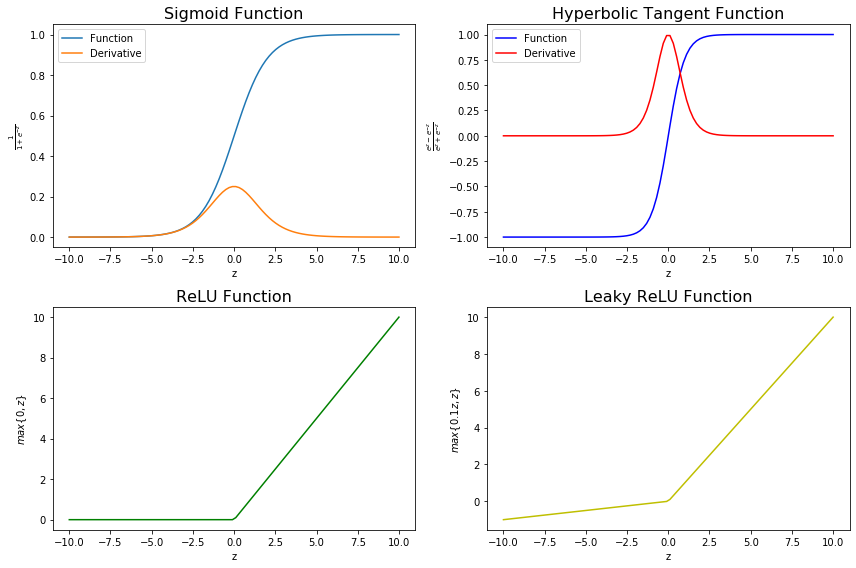

In [19]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label="Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative") 
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize=16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label="Derivative") 
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize=16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize=16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize=16)
plt.tight_layout();

# Feed Forward
Given its inputs from previous layer, each unit computes affine transformation $z = W^Tx + b$ and then apply an activation function g(z) such as ReLU element-wise. During the process, we’ll store (cache) all variables computed and used on each layer to be used in back-propagation. We’ll write first two helper functions that will be used in the L-model forward propagation to make it easier to debug. Keep in mind that on each layer, we may have different activation function.

In [20]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu"):
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])
    return AL, caches

# Cost
We’ll use the binary Cross-Entropy cost. It uses the log-likelihood method to estimate its error. The cost is: The above cost function is convex; however, neural network usually stuck on a local minimum and is not guaranteed to find the optimal parameters. We’ll use here gradient-based learning.

In [21]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
    return cost

# Back-Propagation
Allows the information to go back from the cost backward through the network in order to compute the gradient. Therefore, loop over the nodes starting at the final node in reverse topological order to compute the derivative of the final node output with respect to each edge’s node tail. Doing so will help us know who is responsible for the most error and change the parameters in that direction. The following derivatives’ formulas will help us write the back-propagate functions: Since b^l is always a vector, the sum would be across rows (since each column is an example).

In [22]:
def sigmoid_gradient(dA, Z):
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu"):
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], "sigmoid")

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)

    return grads

In [23]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

# II. Application
'The dataset that we’ll be working on has 209 images. Each image is 64 x 64 pixels on RGB scale. We’ll build a neural network to classify if the image has a cat or not. Therefore, y^i ∈ {0, 1}.'

 - We’ll first load the images.
 - Show sample image for a cat.
 - Reshape input matrix so that each column would be one example. Also, since each image is 64 x 64 x 3, we’ll end up having 12,288 features for each image. Therefore, the input matrix would be 12,288 x 209.
 - Standardize the data so that the gradients don’t go out of control. Also, it will help hidden units have similar range of values. For now, we’ll divide every pixel by 255 which shouldn’t be an issue. However, it’s better to standardize the data to have a mean of 0 and a standard deviation of 1.

Original dimensions:
--------------------
Training: (209, 64, 64, 3), (209,)
Test: (50, 64, 64, 3), (50,)

New dimensions:
---------------
Training: (12288, 209), (1, 209)
Test: (12288, 50), (1, 50)


C:\Users\suagrawa\AppData\Local\Continuum\anaconda3\envs\Optimization-Python\lib\site-packages\ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
C:\Users\suagrawa\AppData\Local\Continuum\anaconda3\envs\Optimization-Python\lib\site-packages\ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """


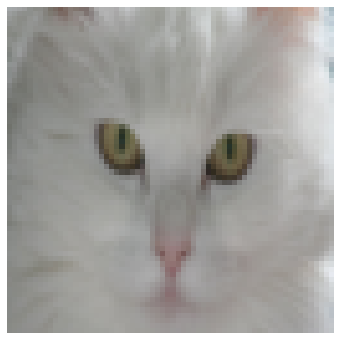

In [25]:
train_dataset = h5py.File("D:\\Ipynb Datasets\\catvnoncat\\train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])
y_train = np.array(train_dataset["train_set_y"])

test_dataset = h5py.File("D:\\Ipynb Datasets\\catvnoncat\\test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
y_test = np.array(test_dataset["test_set_y"])

# print the shape of input data and label vector
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

# plot cat image
plt.figure(figsize=(6, 6))
plt.imshow(X_train[50])
plt.axis("off");

# Transform input data and label vector
X_train = X_train.reshape(209, -1).T
y_train = y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
y_test = y_test.reshape(-1, 50)

# standardize the data
X_train = X_train / 255
X_test = X_test / 255

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

#### Now, our dataset is ready to be used and test our neural network implementation. Let’s first write multi-layer model function to implement gradient-based learning using predefined number of iterations and learning rate.

In [26]:
# Define the multi-layer model using all the helper functions we wrote before
def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=True, hidden_layers_activation_fn="relu"):
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y, activation_fn="relu"):
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100
    return f"The accuracy rate is: {accuracy:.2f}%."



#### Next, we’ll train two versions of the neural network where each one will use different activation function on hidden layers: One will use rectified linear unit (ReLU) and the second one will use hyperbolic tangent function (tanh). Finally we’ll use the parameters we get from both neural networks to classify training examples and compute the training accuracy rates for each version to see which activation function works best on this problem.

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6439
The cost after 900 iterations is: 0.6439
The cost after 1000 iterations is: 0.6439
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6438
The cost after 1400 iterations is: 0.6438
The cost after 1500 iterations is: 0.6437
The cost after 1600 iterations is: 0.6434
The cost after 1700 iterations is: 0.6429
The cost after 1800 iterations is: 0.6413
The cost after 1900 iterations is: 0.6361
The cost after 2000 iterations is: 0.6124
The cost after 2100 iterations is: 0.5112
The cost after 2200 iterations is: 0.4398
The cost after 2300 iterations is: 0.3945
The cost after 2400 iterations is: 0.3156
T

'The accuracy rate is: 68.00%.'

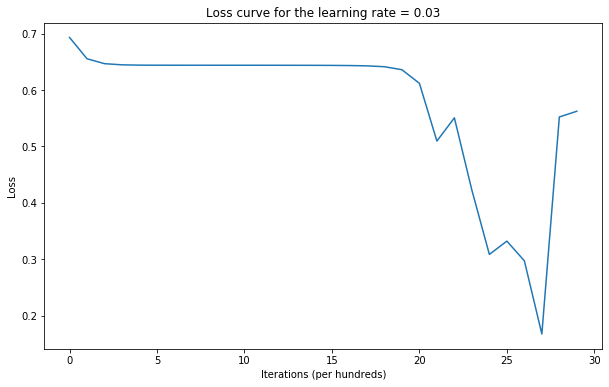

In [27]:
# Setting layers dims
layers_dims = [X_train.shape[0], 5, 5, 1]
# NN with tanh activation fn
parameters_tanh = L_layer_model( X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000, hidden_layers_activation_fn="tanh")
# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="tanh")

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6440
The cost after 900 iterations is: 0.6440
The cost after 1000 iterations is: 0.6440
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6439
The cost after 1400 iterations is: 0.6439
The cost after 1500 iterations is: 0.6439
The cost after 1600 iterations is: 0.6439
The cost after 1700 iterations is: 0.6438
The cost after 1800 iterations is: 0.6437
The cost after 1900 iterations is: 0.6435
The cost after 2000 iterations is: 0.6432
The cost after 2100 iterations is: 0.6423
The cost after 2200 iterations is: 0.6395
The cost after 2300 iterations is: 0.6259
The cost after 2400 iterations is: 0.5408
T

'The accuracy rate is: 42.00%.'

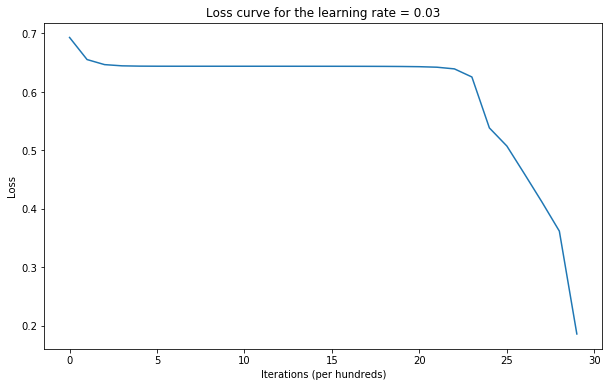

In [28]:
# NN with relu activation fn
parameters_relu = L_layer_model( X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000, hidden_layers_activation_fn="relu")
# Print the accuracy
accuracy(X_test, parameters_relu, y_test, activation_fn="relu")